# Data augmentation

## 0. Setup

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 1. Download a dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


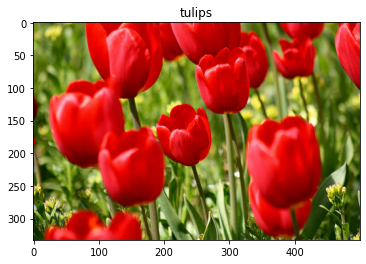

In [4]:
# Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## 2. Use Keras preprocessing layers

### i. Resizing and rescaling

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

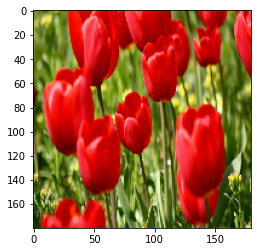

In [6]:
# You can see the result of applying these layers to an image.

result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
# You can verify the pixels are in [0-1]

print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### ii. Data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

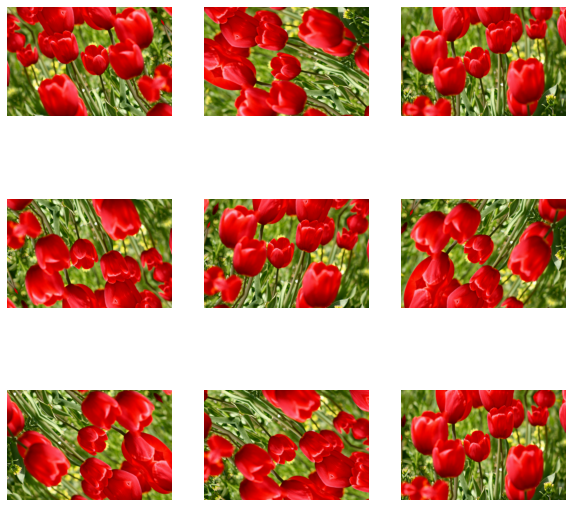

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### iii. Two options to use the preprocessing layers

### Option 1: Make the preprocessing layers part of your model

In [11]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])

### Option 2: Apply the preprocessing layers to your dataset

In [12]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

### iv. Apply the preprocessing layers to the datasets

In [13]:
# Note: data augmentation should only be applied to the training set.

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### v. Train a model

In [15]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 6s 40ms/step - loss: 1.7355 - accuracy: 0.2850 - val_loss: 1.1870 - val_accuracy: 0.5477
Epoch 2/5
92/92 [==============================] - 2s 23ms/step - loss: 1.1510 - accuracy: 0.5333 - val_loss: 1.0123 - val_accuracy: 0.5940
Epoch 3/5
92/92 [==============================] - 2s 23ms/step - loss: 1.0455 - accuracy: 0.5855 - val_loss: 1.0685 - val_accuracy: 0.5886
Epoch 4/5
92/92 [==============================] - 2s 23ms/step - loss: 0.9944 - accuracy: 0.5977 - val_loss: 0.9063 - val_accuracy: 0.6649
Epoch 5/5
92/92 [==============================] - 2s 23ms/step - loss: 0.9173 - accuracy: 0.6406 - val_loss: 0.9640 - val_accuracy: 0.6512


In [18]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 0s 9ms/step - loss: 0.9570 - accuracy: 0.6213
Accuracy 0.6212534308433533


### vi. Custom data augmentation

In [19]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [20]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

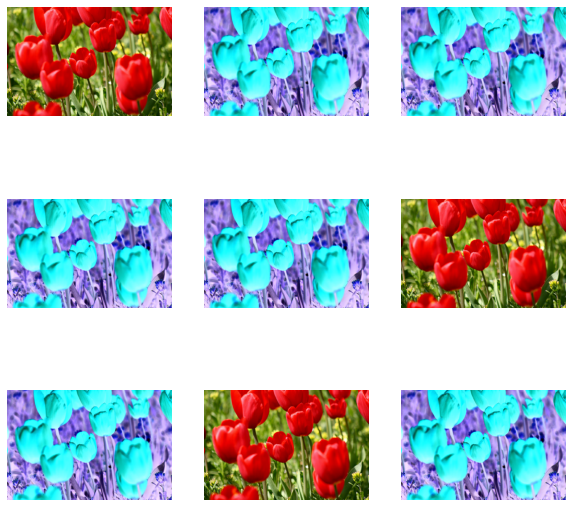

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [22]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

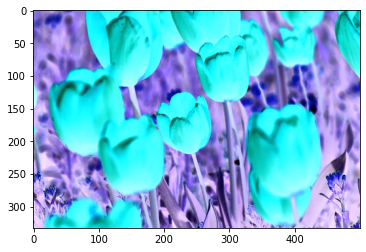

In [23]:
_ = plt.imshow(RandomInvert()(image)[0])

## 3. Using tf.image

In [24]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

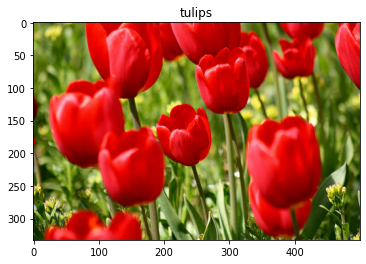

In [25]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [26]:
# Let's use the following function to visualize and compare the original and augmented images side-by-side.

def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### i. Data augmentation

- Flipping the image
- Grayscale the image
- Saturate the image
- Change image brightness
- Center crop the image
- Rotate the image

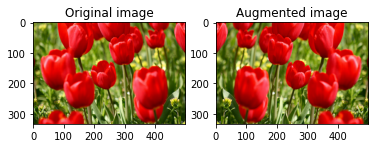

In [27]:
# Flipping the image

flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

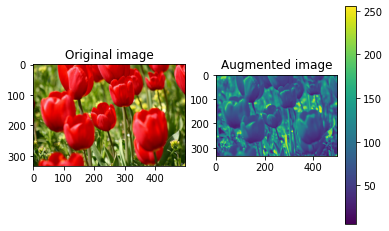

In [28]:
# Grayscale the image

grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

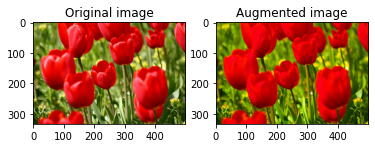

In [29]:
# Saturate the image

saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

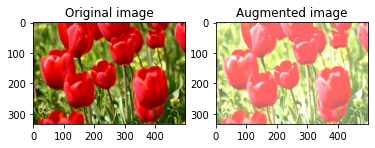

In [30]:
# Change image brightness

bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

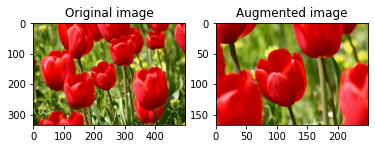

In [31]:
# Center crop the image

cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)

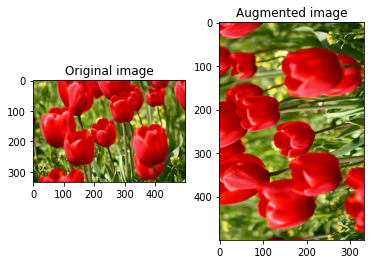

In [32]:
# Rotate the image

rotated = tf.image.rot90(image)
visualize(image, rotated)

### ii. Random transformations

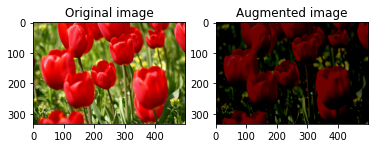

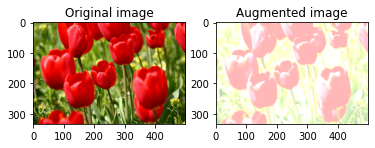

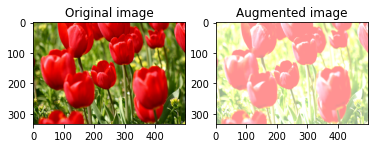

In [33]:
# Randomly change image brightness

for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

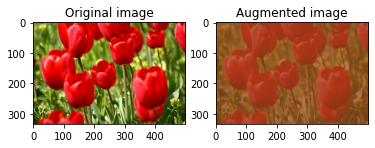

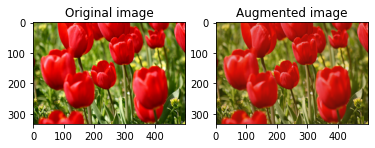

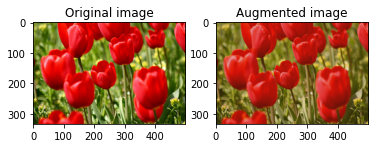

In [34]:
# Randomly change image contrast

for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

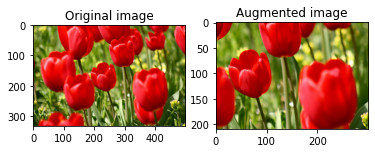

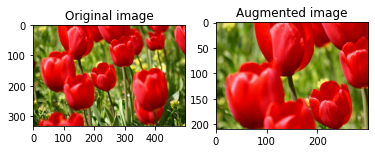

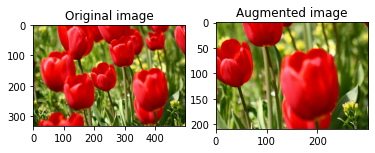

In [35]:
# Randomly crop an image

for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### iii. Apply augmentation to a dataset

In [36]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [37]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [38]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### Option 1: Using tf.data.experimental.Counter()

In [39]:
# Create counter and zip together with train dataset
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

In [40]:
# Map the augment function to the training dataset.

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [41]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


In [42]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

### Option 2: Using tf.random.Generator

In [43]:
# Create a generator
rng = tf.random.Generator.from_seed(123, alg='philox')

In [44]:
# A wrapper function for updating seeds
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

In [45]:
# Map the wrapper function f to the training dataset.

train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [46]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [47]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

### These datasets can now be used to train a model as shown previously.

# reference

### https://tensorflow.google.cn/tutorials/images/data_augmentation#apply_augmentation_to_a_dataset